In [1]:
# https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_deepOnet_in_JAX.ipynb
import matplotlib.pyplot as plt
# import neuromancer.slim as slim
import numpy as np
import torch
import torch.nn.functional as F

import sys
sys.path.append('neuromancer/src')

from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import activations, blocks
from neuromancer.problem import Problem
from neuromancer.system import Node, System
from neuromancer.trainer import Trainer

## Current issues
* Do I need to explicitly convert numpy arrays to pytorch tensors for the dictdataset?
* Batch implementation? is this handled by problem and dataloaders
* Lambda functionality for multiply & bias
* Loss function implementation
* Need to add a node pre trunk net to reshape the input matrix potentially

In [2]:
data_dir = "datasets/deeponet_antiderivative_aligned"

## Prepare train data

In [3]:
# load original dataset numpy arrays
dataset_train = np.load(f"{data_dir}/antiderivative_aligned_train.npz", allow_pickle=True)

 ## Note: transposing branch input because DictDataset in Neuromancer needs all tensors in the dict to have the same shape at index 0
branch_inputs_train = dataset_train["X"][0].T
trunk_inputs_train = dataset_train["X"][1]
outputs_train = dataset_train["y"].T

print(branch_inputs_train.shape)
print(trunk_inputs_train.shape)
print(outputs_train.shape)

## Global definition of Nu and Nsamples:
## This example has 100 points (resolution of x and u(x))
## and 150 samples of functions
Nu = outputs_train.shape[0]
Nsamples = outputs_train.shape[1]
print(f'Nu = {Nu}')
print(f'Nsamples = {Nsamples}')

(100, 150)
(100, 1)
(100, 150)
Nu = 100
Nsamples = 150


In [4]:
# convert to pytorch tensors of float type
t_branch_inputs_train = torch.from_numpy(branch_inputs_train).float()
t_trunk_inputs_train = torch.from_numpy(trunk_inputs_train).float()
t_outputs_train = torch.from_numpy(outputs_train).float()

print(t_branch_inputs_train.shape)
print(t_trunk_inputs_train.shape)
print(t_outputs_train.shape)


# create named dictionary dataset
samples_train = {
    "branch_inputs": t_branch_inputs_train,
    "trunk_inputs": t_trunk_inputs_train,
    "outputs": t_outputs_train
}

train_data = DictDataset(samples_train, name="train")

torch.Size([100, 150])
torch.Size([100, 1])
torch.Size([100, 150])


In [5]:
dataset_test = np.load(f"{data_dir}/antiderivative_aligned_test.npz", allow_pickle=True)
branch_inputs_test = dataset_test["X"][0].T
trunk_inputs_test = dataset_test["X"][1]
outputs_test = dataset_test["y"].T

print(branch_inputs_test.shape)
print(trunk_inputs_test.shape)
print(outputs_test.shape)

t_branch_inputs_test = torch.from_numpy(branch_inputs_test).float()
t_reshaped_trunk_inputs_test = torch.from_numpy(trunk_inputs_test).float()
t_outputs_test = torch.from_numpy(outputs_test).float()

samples_test = {
    "branch_inputs": t_branch_inputs_test,
    "trunk_inputs": t_reshaped_trunk_inputs_test,
    "outputs": t_outputs_test
}
# create named dictionary dataset
test_data = DictDataset(samples_test, name="test")

(100, 1000)
(100, 1)
(100, 1000)


In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=150, collate_fn=train_data.collate_fn, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=150, collate_fn=test_data.collate_fn, shuffle=False)

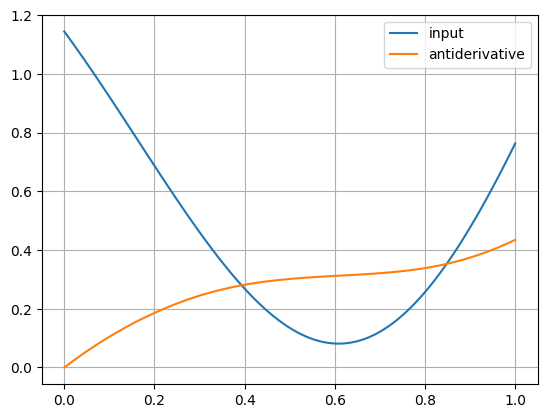

In [7]:
# Due to the dataset being aligned, we can use the trunk inputs as a grid
k = 2
plt.plot(
    train_data.datadict['trunk_inputs'],
    train_data.datadict['branch_inputs'][:,k],
    label="input",
)
plt.plot(
    train_data.datadict['trunk_inputs'],
    train_data.datadict['outputs'][:,k],
    label="antiderivative",
)
plt.legend()
plt.grid()

## Define nodes

In [8]:
train_data.datadict.keys()

dict_keys(['branch_inputs', 'trunk_inputs', 'outputs'])

In [9]:
train_data.datadict["branch_inputs"].shape

torch.Size([100, 150])

In [10]:
# Can I create a system composed of MLPS? Do I even need system or can I just wrap with nodes?
# inputs from jax example

in_size_branch = Nu
width_size = 40
depth_branch = 2
interact_size = 40
activation = torch.nn.ReLU
linear_map = torch.nn.Linear
# key?
# should bias be true? Looks like Yes, https://docs.kidger.site/equinox/api/nn/mlp/
block_branch = blocks.MLP(
    insize=in_size_branch,
    outsize=interact_size,
    bias=True,
    nonlin=activation,
    hsizes=[width_size] * depth_branch
)
branch_net = Node(block_branch, ['reshaped_branch_inputs'], ['branch_outputs'], name="branch_net")
print(branch_net.input_keys)
print(branch_net.output_keys)
print(branch_net({"reshaped_branch_inputs": t_branch_inputs_train.T}))
print(branch_net({"reshaped_branch_inputs": t_branch_inputs_train.T})['branch_outputs'].shape)


['reshaped_branch_inputs']
['branch_outputs']
{'branch_outputs': tensor([[-0.1791,  0.0513,  0.2708,  ...,  0.0021, -0.2571,  0.2520],
        [-0.1896, -0.0302,  0.1224,  ...,  0.0380, -0.0138,  0.1270],
        [-0.1465, -0.0744,  0.0680,  ...,  0.0376, -0.0077,  0.1117],
        ...,
        [-0.1573,  0.0235,  0.1737,  ..., -0.0187, -0.1431,  0.1781],
        [-0.1476, -0.0406,  0.1615,  ..., -0.1025,  0.0126,  0.1322],
        [-0.1669, -0.0130,  0.1487,  ...,  0.0440, -0.1266,  0.1204]],
       grad_fn=<AddmmBackward0>)}
torch.Size([150, 40])


In [11]:
## Transpose for branch net
lam_transpose = lambda x_in: torch.transpose(x_in, 0, 1)
node_transpose_branch = Node(lam_transpose, ['branch_inputs'], ["reshaped_branch_inputs"], name="transpose")


In [12]:
in_size_trunk = 1
depth_trunk = 2
block_trunk = blocks.MLP(
    insize=in_size_trunk,
    outsize=interact_size,
    bias=True,
    nonlin=activation,
    hsizes= [width_size]*depth_trunk
)
trunk_net = Node(block_trunk, ["trunk_inputs"], ["trunk_outputs"], name="trunk_net")
print(trunk_net.input_keys)
print(trunk_net.output_keys)

print(trunk_net({'trunk_inputs':train_data.datadict['trunk_inputs']})["trunk_outputs"])
print(trunk_net({'trunk_inputs':train_data.datadict['trunk_inputs']})["trunk_outputs"].shape)


['trunk_inputs']
['trunk_outputs']
tensor([[ 0.1122, -0.0437,  0.0734,  ...,  0.1455,  0.0067,  0.0814],
        [ 0.1114, -0.0427,  0.0722,  ...,  0.1455,  0.0087,  0.0826],
        [ 0.1107, -0.0415,  0.0709,  ...,  0.1454,  0.0110,  0.0840],
        ...,
        [ 0.0073,  0.2008, -0.0606,  ...,  0.0598,  0.1847,  0.2016],
        [ 0.0069,  0.2027, -0.0634,  ...,  0.0588,  0.1864,  0.2035],
        [ 0.0065,  0.2047, -0.0662,  ...,  0.0578,  0.1881,  0.2053]],
       grad_fn=<AddmmBackward0>)
torch.Size([100, 40])


In [13]:
# bias = torch.zeros(1, requires_grad=True)
# No inputs for bias?
#node_bias = Node(bias, [], ['bias_output'], name="bias")

In [14]:
## Todo: add a bias term here
lam_multiply = lambda branch_output, trunk_output: torch.matmul(branch_output, trunk_output.T)
node_multiply = Node(lam_multiply, ['branch_outputs', 'trunk_outputs'], ['g'], name="multiply_and_bias")

In [15]:
print(branch_net)
print(node_transpose_branch)
print(trunk_net)
print(node_multiply)

branch_net(reshaped_branch_inputs) -> branch_outputs
transpose(branch_inputs) -> reshaped_branch_inputs
trunk_net(trunk_inputs) -> trunk_outputs
multiply_and_bias(branch_outputs, trunk_outputs) -> g


In [16]:
## Testing all the nets to see if they are returning the expected shapes
res_transpose = node_transpose_branch({'branch_inputs':train_data.datadict['branch_inputs']})["reshaped_branch_inputs"]
res_branch = branch_net({'reshaped_branch_inputs':res_transpose})["branch_outputs"]
res_trunk = trunk_net({'trunk_inputs':train_data.datadict['trunk_inputs']})["trunk_outputs"]
res_multiply = node_multiply({'branch_outputs':res_branch, 'trunk_outputs':res_trunk})['g']
print(res_transpose.shape)
print(res_branch.shape)
print(res_trunk.shape)
print(res_multiply.shape)


torch.Size([150, 100])
torch.Size([150, 40])
torch.Size([100, 40])
torch.Size([150, 100])


In [17]:
var_y_est = variable("g")
var_y_true = variable("outputs")

nodes = [node_transpose_branch,branch_net, trunk_net, node_multiply]
#nodes = [branch_net, lam_transpose, trunk_net, lam_multiply]
# sol_map = Node(nodes, ['branch_inputs', 'reshaped_trunk_inputs'], ['branch_outputs', 'trunk_outputs'], name="map")

#var_loss = F.mse_loss(var_y_est, var_y_true)
var_loss = (var_y_est == var_y_true.T)^2
var_loss.name = "residual_loss"
objectives = [var_loss]

loss = PenaltyLoss(objectives, constraints=[])

problem = Problem(nodes, loss=loss, grad_inference=True)


In [18]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=1e-4, eps=1e-6)
epochs = 3000

trainer = Trainer(
    problem,
    train_loader,
    optimizer=optimizer,
    epochs=epochs,
    epoch_verbose=100,
    train_metric='train_loss',
    dev_metric='test_loss',
    eval_metric='train_loss',
    warmup = epochs
)

In [23]:
best_model = trainer.train()

# load best trained model
problem.load_state_dict(best_model)

epoch: 3000  train_loss: 0.0001584590645506978
epoch: 3100  train_loss: 0.00013163707626517862
epoch: 3200  train_loss: 0.00010209985339315608
epoch: 3300  train_loss: 7.553565228590742e-05
epoch: 3400  train_loss: 5.763576700701378e-05
epoch: 3500  train_loss: 4.748848732560873e-05
epoch: 3600  train_loss: 4.155680289841257e-05
epoch: 3700  train_loss: 3.7789821362821385e-05
epoch: 3800  train_loss: 3.5062770621152595e-05
epoch: 3900  train_loss: 3.283978730905801e-05
epoch: 4000  train_loss: 3.1048522942001e-05
epoch: 4100  train_loss: 2.9411450668703765e-05
epoch: 4200  train_loss: 2.8045595172443427e-05
epoch: 4300  train_loss: 2.668509114300832e-05
epoch: 4400  train_loss: 2.5494802684988827e-05
epoch: 4500  train_loss: 2.4487839255016297e-05
Early stopping!!!


<All keys matched successfully>

In [24]:
# Evaluate trained PINN on test data (all the data in the domain)
val_u = problem(train_data.datadict)


## Compare results

torch.Size([100, 1]) torch.Size([100, 1])


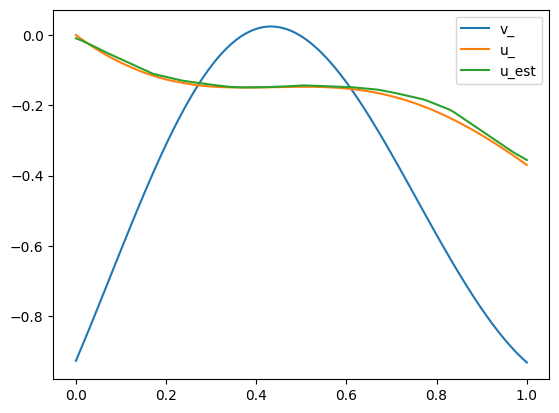

In [26]:
k = 20 # k is the k-th function among those 150 sampled v functions
v_ = test_data.datadict["branch_inputs"][:,k].reshape(-1,1)
x_ = test_data.datadict["trunk_inputs"]
print(v_.shape, x_.shape)


## Note: Neuromancer needs a better forward method to 'predict' after the model is trained
## This is a workaround that I found (forward pass with zero 'outputs')
## You could also use a problem.step({'branch_inputs':v_, 'trunk_inputs':x_}) here, but that is not as great
## as it computes the gradients again.
res = problem.predict({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = test_data.datadict["outputs"][:,k]
u_est = res['g'].T

plt.plot(x_.detach().numpy(), v_.detach().numpy(),label='v_')
plt.plot(x_.detach().numpy(), u_.detach().numpy(),label='u_')
plt.plot(x_.detach().numpy(), u_est.detach().numpy(),label='u_est')

plt.legend()


torch.Size([100, 1]) torch.Size([100, 1])


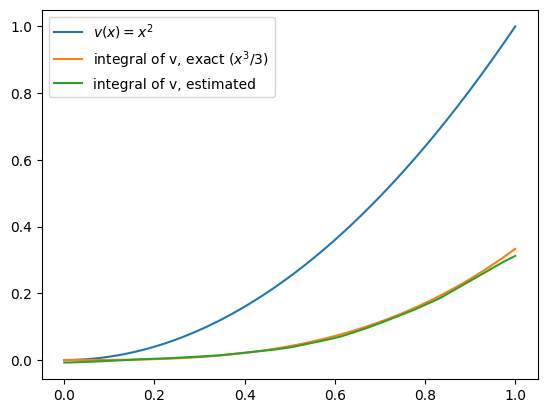

In [27]:
x_ = train_data.datadict["trunk_inputs"]
v_ = torch.pow(x_,2).reshape(-1,1)

print(v_.shape, x_.shape)
res = problem.step({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = (1./3.)*torch.pow(x_,3).reshape(-1,1)
u_est = res['g'].T

plt.plot(x_.detach().numpy(), v_.detach().numpy(),label='$v(x) = x^2$')
plt.plot(x_.detach().numpy(), u_.detach().numpy(),label='integral of v, exact ($x^3/3$)')
plt.plot(x_.detach().numpy(), u_est.detach().numpy(),label='integral of v, estimated')
plt.legend()
